In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special as scsp
import astropy.constants as astropy_const
import astropy.units as u
import scipy.integrate as integrate
from scipy.signal import argrelmin
plt.rcParams.update({'font.size': 17})

## Functions

### 1) Emission Spectrum for single electron

In [2]:
def plot_Single_e_Spectrum(gamma,w_Hz):
    # pipeline to plot spectrum of single e of gamma 
    ###   Input: single gamma
    ###         w_Hz is array of frequencies with units of frequency
    const_dict=constants()
    q=const_dict['q']       # Charge of an electron
    B=const_dict['B'] # Magnetic field of ISM, CHECK
    m=const_dict['m_e'] # Mass of an electron
    c=const_dict['c']
    alpha=const_dict['alpha']
    #--------#
    y=gamma
    w_c=w_crit(y)
    x=(w_Hz/w_c).decompose()

    synch_F=F(x)
    P=3**0.5 * q**3 * B* np.multiply(np.sin(alpha),synch_F) / (2*np.pi*m*c**2)

    plt.plot(w_Hz,P,label=fr'$\gamma=10^{{{np.log10(gamma)}}}$')
    plt.xlabel(r'$\omega$')
    plt.ylabel(r'P($\omega$)')
    plt.grid(alpha=0.4)
    plt.vlines(0.29*w_c.value,max(P.value)*0.9,max(P.value)*1.1,linestyle='--')
    plt.text(0.29*w_c.value,max(P.value)*1.05,' x=0.29')
    plt.title(fr'Single e$^-$ Spectrums')
    plt.legend()
    return
def constants():
    dict_={'q':astropy_const.e.esu,
           'B':1e-3 * (u.cm**(-1/2)*u.g**(1/2)*u.s**(-1)),
           'm_e':astropy_const.m_e.cgs,
           'c':astropy_const.c.cgs,
          'alpha':60 * (np.pi/180)}
    return dict_
def F(x):
    # (Aharonian et. al 2018 D6)
    A=2.15*(x**(1/3)) * ((1+3.06*x)**(1/6))
    B_num=1+ 0.884*(x**(2/3)) + 0.471*(x**(4/3))
    B_den=1+ 1.64*(x**(2/3)) + 0.974*(x**(4/3))
    approx_F= A*( B_num/B_den )*np.exp(-x)
    return np.array(approx_F)
def w_crit(y):
    const_dict=constants()
    q=const_dict['q']       # Charge of an electron
    B=const_dict['B'] # Magnetic field of ISM, CHECK
    m=const_dict['m_e'] # Mass of an electron
    c=const_dict['c']
    #--------#
    y=np.array(y)  
    alpha=60 * (np.pi/180)
    w_c=((3/2)*y**2 *(q*B)*np.sin(alpha) /(m*c)).decompose() #critical frequency
    return w_c

### 2) Emission Spectrum assuming a power law distribution of electrons 

In [3]:
def calctot_Spectrum_funcGamma(w,gammas,p):
    # pipeline to plot power spectrum of single e of gamma y
    const_dict=constants()
    q=const_dict['q']       # Charge of an electron
    B=const_dict['B'] # Magnetic field of ISM, CHECK
    m=const_dict['m_e'] # Mass of an electron
    c=const_dict['c']
    #--------#
    alpha=60 * (np.pi/180)
    P_constants=(np.sqrt(3)*(q**3)*B*np.sin(alpha) / (2*np.pi*m*c**2)).decompose()
    C=10**30 
    Ptot_grid=[]
    for w_i in w:
        w_c=lambda y: (3*y**2 *(q*B)*np.sin(alpha) /(2*m*c)).decompose() #critical frequency
        x_i=lambda y:(w_i/w_c(y)).decompose()
        F_i=lambda y: F(x_i(y))
        Ptot_i=lambda y:(C *y**(-p) *F_i(y) * P_constants)

        Ptot_grid.append(Ptot_i(np.array(gammas)))
    Ptot=np.trapz(Ptot_grid,gammas,axis=1)
    return np.array(Ptot)

### 3) Include cooling break

In [4]:
def calctot_Spectrum_funcGamma_cool(w,gammas,p):

    # pipeline to plot power spectrum of single e of gamma y
    const_dict=constants()
    q=const_dict['q']       # Charge of an electron
    B=const_dict['B'] # Magnetic field of ISM, CHECK
    m=const_dict['m_e'] # Mass of an electron
    c=const_dict['c']
    alpha=const_dict['alpha']
    #--------#
    P_constants=(np.sqrt(3)*(q**3)*B*np.sin(alpha) / (2*np.pi*m*c**2)).decompose()
    C=10**34 *u.cm**-3
    Ptot_grid=[]

    for w_i in w:
        w_c=lambda y: (3*y**2 *(q*B)*np.sin(alpha) /(2*m*c)).decompose() #critical frequency
        x_i=lambda y:(w_i/w_c(y)).decompose()
        F_i=lambda y: F(x_i(y))
        N_i=lambda y: N_cool(y,p)
        Ptot_i=lambda y:(C *N_cool(y,p) *F_i(y) * P_constants)

        Ptot_grid.append(Ptot_i(np.array(gammas)))
    Ptot=np.trapz(Ptot_grid,gammas,axis=1)
    return np.array(Ptot)
def N_cool(gammas,p):
    # N propto gamma^{-p} 
    # N propto gamma^{-p-1}
    wc=10**7.5 *u.Hz
    gamma_c=gamma_cool(wc) 
    
    gammas_power=gammas[np.where(gammas<gamma_c)]**(-p)
    gammas_cool=gammas[np.where(gammas>=gamma_c)]**(-(p+1))
    scaling=gammas_power[-1]/gammas_cool[0]
    gammas_cool=scaling*gammas[np.where(gammas>gamma_c)]**(-(p+1))
    N=np.concatenate((gammas_power,gammas_cool))
    return N

def gamma_cool(wc):
    const_dict=constants()
    q=const_dict['q']       # Charge of an electron
    B=const_dict['B'] # Magnetic field of ISM, CHECK
    m=const_dict['m_e'] # Mass of an electron
    c=const_dict['c']
    alpha=const_dict['alpha']
    #--------#
    y=((2/3)*(m*c)*wc/(q*B*np.sin(alpha)))**(1/2)
    return y.decompose()
def synchspec_grid(w,gammas,p):

    # pipeline to plot power spectrum of single e of gamma y
    const_dict=constants()
    q=const_dict['q']       # Charge of an electron
    B=const_dict['B'] # Magnetic field of ISM, CHECK
    m=const_dict['m_e'] # Mass of an electron
    c=const_dict['c']
    alpha=const_dict['alpha']
    #--------#
    P_constants=(np.sqrt(3)*(q**3)*B*np.sin(alpha) / (2*np.pi*m*c**2)).decompose()
    C=10**34 *u.cm**-3
    Ptot_grid=[]

    for w_i in w:
        w_c=lambda y: (3*y**2 *(q*B)*np.sin(alpha) /(2*m*c)).decompose() #critical frequency
        x_i=lambda y:(w_i/w_c(y)).decompose()
        F_i=lambda y: F(x_i(y))
        Ptot_i=lambda y:(C *N_cool(y,p) *F_i(y) * P_constants)

        Ptot_grid.append(Ptot_i(np.array(gammas)))
    return Ptot_grid
def intersect(x,y_1,y_2):
    diff=abs(np.subtract(y_1,y_2))
    id_=scipy.signal.argrelmin(diff)[0][0]
    return x[id_]
def fit_line(Pw_array,w_array,w_val,p,flag):
    y=Pw_array[find_nearest(w_array, w_val)]
    #w_val=w_val.value
    if flag == 'cooling':
        A=y/(w_val**(-p/2))
    elif flag == 'power':
        A=y/(w_val**(-(p-1)/2))
    elif flag == 'min':
        A=y/(w_val**(1/3))
    return A
def find_nearest(array, value):
    array = np.array(array)
    id_ = (np.abs(array - value)).argmin()
    return id_

### 4) Introduce $~~\gamma_{min}$

# Intro


$$ \omega_c = \frac{3}{2} \gamma^2 \frac{q B}{ m c} sin(\alpha)$$

$$F(x) = x \int_x ^\infty {K_{5/3}(\xi)~d\xi}  ~~~~~~ \text{R.L}(6.31c)$$
The above form of F(x) is computationally expensive and this motivates the below highly accurate approximation found in Appendix D of [Aharonian et.al 2018](https://arxiv.org/pdf/1006.1045.pdf)
$$F(x) \approx 2.15x^{1/3}(1+3.06x)^{1/6} * \frac{1+0.884x^{2/3}+0.471x^{4/3}}{1+ 1.64x^{2/3} + 0.974x^{4/3}} e^{-x}$$

$$P(\omega) = \frac{\sqrt{3}}{2\pi} \frac{q^3 B sin(\alpha)}{mc^2} F(\omega/\omega_c) ~~~~~~ \text{Lect}~15(17)$$

******
## 1) Emission Spectrum for single electron

> #### Code:

Create our $\gamma$ arrays which then set our arrays for $\omega_{crit}$ and $\omega$

In [5]:
gamma_bounds=[1,10**5]
gammas=np.linspace(min(gamma_bounds),max(gamma_bounds),num=10**5)
min_w_c=w_crit(min(gammas)).value # Hz
max_w_c=w_crit(max(gammas)).value # Hz
#Scaling factors
minscale=10**-9;maxscale=10**0.5 
#Create omega crit arrays and then omega from omega crit
log_min_wc=np.log10(minscale*min_w_c)
log_max_wc=np.log10(maxscale*max_w_c)
w=np.logspace(log_min_wc,log_max_wc,num=1000) *u.Hz
nu = w/(2.0*np.pi)

This cell below plots the emission spectra for a single electron at a single Lorentz factor. The gammas shown are $10^0, 10^3, 10^{4.5}$ which represents the range of Lorentz factors we cover.

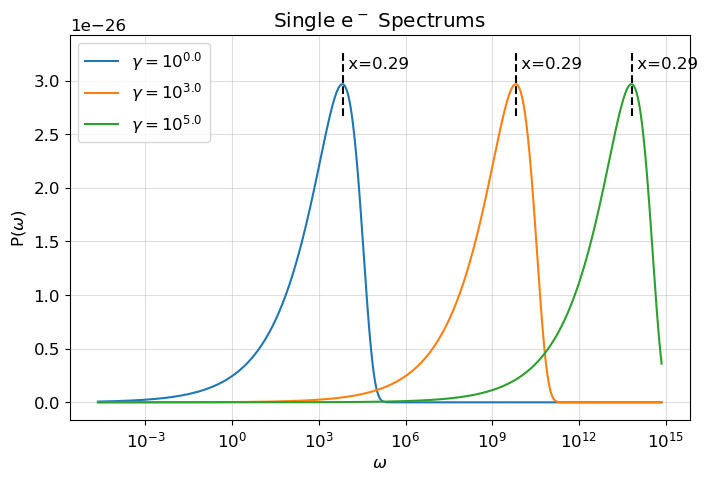

In [6]:
plt.rcParams.update({'font.size': 12});plt.figure(figsize=(8,5)) 
for y_i in [10**0,10**3,max(gammas)]:
    plot_Single_e_Spectrum(y_i,w);plt.xscale('log')

******
## 2) Emission Spectrum assuming a power law distribution of electrons 

$$N(\gamma)~d\gamma ~=~ C \gamma^{-p} ~d\gamma ~~~(6.20b)$$
$$P_{tot}(\omega) = C~\int_{\gamma_1} ^{\gamma_2} {P(\omega)~\gamma^{-p}~~d\gamma}~~~(6.21a)$$


> #### Code:

These cells plot the emission spectrum for an array of electrons which follow a power law as a function of gamma. The value p controls the shape (or slope in log-log space) of this distribution.

> > #### Single p value

Create Emission Spectrum arrays including a power law distribution of electrons with p=2.5

In [9]:
p_25=2.5     # Power law power
s_p25=(p_25-1)/2 # Corresponding spectral index
Ptot_power=calctot_Spectrum_funcGamma(w,gammas,p=p_25) # Calculate total spectrum

Create power law fits and find intersection of fits to give and $\omega_{min}$ value

In [10]:
pow_fit=fit_line(Ptot_power,w,10**8,p_25,'power')*w.value**(-(p_25 - 1.0)/2.0) #fit power law section
min_fit=fit_line(Ptot_power,w,10**1,p_25,'min')*w.value**(1/3) #fit gamma min section
wmin=intersect(w,pow_fit,min_fit).value #find intersection of pow and min which gives omega min

Plot the afterglow emission spectrum alongside the electron number power law function

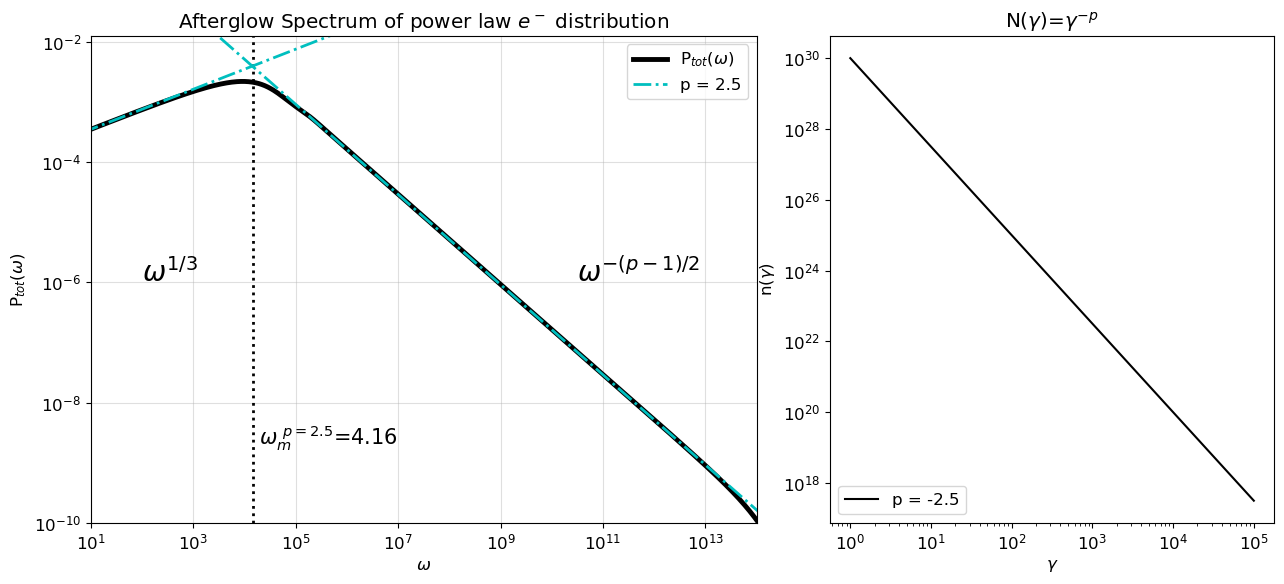

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(13, 6),gridspec_kw={'width_ratios': [1.5,1]})
plt.rcParams.update({'font.size': 12})
ybounds=[10**-10,10**-1.9];lw_wm=2;
fitwidth=2;min_={'color':'magenta','line':'-.'};cool_={'color':'darkorange','line':'-.'};pow_={'color':'c','line':'-.'}
ax1.plot(w,Ptot_power,'k',label=r'P$_{tot}(\omega)$',linewidth=3.5)
ax1.plot(w,pow_fit,color=pow_['color'],linestyle=cool_['line'],linewidth=fitwidth,label='p = 2.5')
ax1.plot(w,min_fit,color=pow_['color'],linestyle=min_['line'],linewidth=fitwidth)
ax1.vlines(wmin,ybounds[0],ybounds[1],linewidth=lw_wm,color='black',alpha=0.99,linestyle=':')
ax1.text(1.3*wmin,20*ybounds[0],fr'$\omega_{{m}}^{{ ~p=2.5}}$={np.log10(wmin):.2f}',{'fontsize': 15})
ax1.text(10**2,10**-6,r'$\omega^{1/3}$',{'fontsize': 20});ax1.text(10**10.5,10**-6,r'$\omega^{-(p-1)/2}$',{'fontsize': 20})
ax1.legend();ax1.set_xscale('log');ax1.set_yscale('log');
ax1.set_xlabel(r'$\omega$');ax1.set_ylabel(r'P$_{tot}(\omega$)');ax1.set_xlim([10**1,10**14]);ax1.set_ylim(ybounds[0],ybounds[1])
ax1.set_title(fr'Afterglow Spectrum of power law $e^-$ distribution');ax1.grid(alpha=0.4)
ax2.plot(gammas,10**30*np.power(gammas,-2.5),'k',label='p = -2.5');ax2.set_yscale('log');ax1.grid(alpha=0.4)
ax2.set_ylabel(r'n($\gamma$)');plt.xlabel(r'$\gamma$');ax2.set_title(r'N($\gamma$)=$\gamma^{-p}$');ax2.set_xscale('log'); plt.legend(loc='lower left');plt.tight_layout(w_pad=0.1)

##### Left Plot: Emission spectra assuming a p value of 2.5
##### Right Plot: Number electron function assuming a p value of 2.5


> > #### Testing new p values

Create Emission Spectrum arrays including a power law distribution of electrons with p values of p=4 and p=1.5

In [15]:
p_4=4.0;s_p4=(p_4-1)/2 #p value and spectral index s
Ptot_p4=calctot_Spectrum_funcGamma(w,gammas,p=p_4)
####
p_15=1.5;s_p15=(p_15-1)/2 #p value and spectral index s
Ptot_p15=calctot_Spectrum_funcGamma(w,gammas,p=p_15)

Create power law fits and find intersection of fits to give $\omega_{min}$ value


In [16]:
pow_fit_4=fit_line(Ptot_p4,w,10**8,p_4,'power')*(w.value)**(-(4 - 1.0)/2.0)
min_fit_4=fit_line(Ptot_p4,w,10**3,p_4,'min')*w.value**(1/3)
wmin_4=intersect(w,pow_fit_4,min_fit_4).value #find intersection of pow and min which gives omega min
#------#
pow_fit_15=fit_line(Ptot_p15,w,10**8,p_15,'power')*w.value**(-(1.5 - 1.0)/2.0)
min_fit_15=fit_line(Ptot_p15,w,10**3,p_15,'min')*w.value**(1/3)
wmin_15=intersect(w,pow_fit_15,min_fit_15).value #find intersection of pow and min which gives omega min

Plot the afterglow emission spectrum alongside the electron number power law function, assuming multiple p values

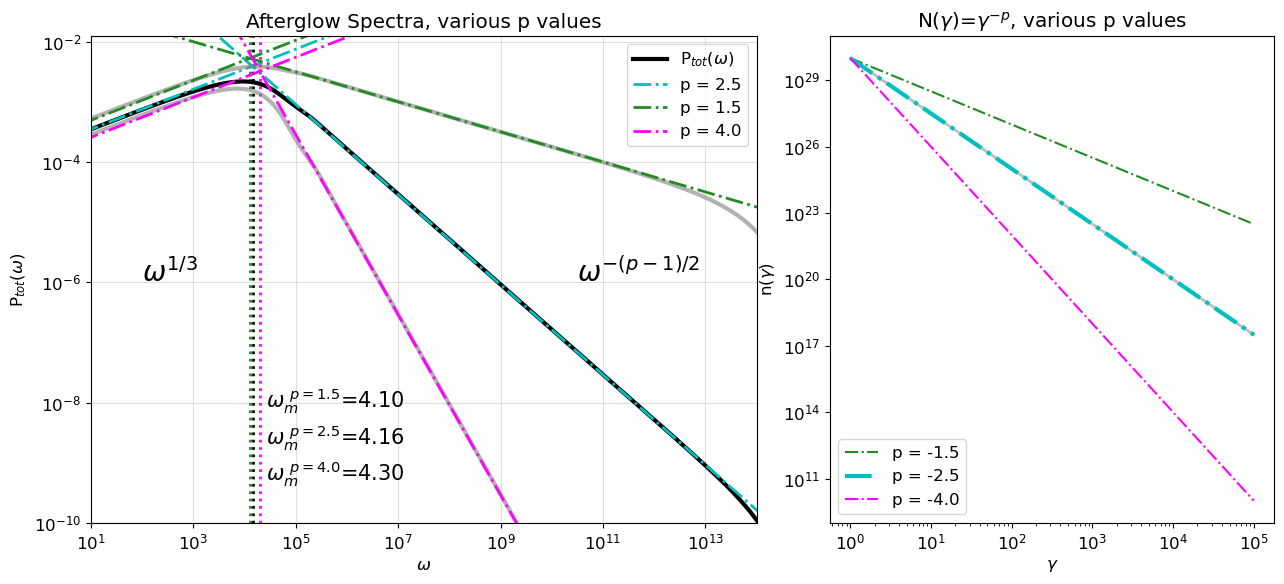

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(13, 6),gridspec_kw={'width_ratios': [1.5,1]})
plt.rcParams.update({'font.size': 12})
lw=3;fit_lw=1.75;pnew_alpha=0.6;lw_wm=2;ybounds=[10**-10,10**-1.9]
ax1.plot(w,Ptot_power,'k',label=r'P$_{tot}(\omega)$',linewidth=lw)
ax1.plot(w,pow_fit,color=pow_['color'],linestyle=cool_['line'],linewidth=fitwidth,label='p = 2.5')
ax1.plot(w,min_fit,color=pow_['color'],linestyle=min_['line'],linewidth=fitwidth)
ax1.vlines(wmin,ybounds[0],ybounds[1],linewidth=lw_wm,color='black',alpha=0.99,linestyle=':')
#---------#
p15color='forestgreen'
ax1.plot(w,Ptot_p15,color='grey',linewidth=lw,alpha=pnew_alpha)
ax1.plot(w,pow_fit_15,color=p15color,linestyle=cool_['line'],linewidth=fitwidth,label='p = 1.5')
ax1.plot(w,min_fit_15,color=p15color,linestyle=min_['line'],linewidth=fitwidth)
ax1.vlines(wmin_15,ybounds[0],ybounds[1],linewidth=lw_wm,color=p15color,alpha=0.99,linestyle=':')
#---------#
p4color='fuchsia'
ax1.plot(w,Ptot_p4,color='grey',linewidth=lw,alpha=pnew_alpha)
ax1.plot(w,pow_fit_4,color=p4color,linestyle=pow_['line'],linewidth=fitwidth,label='p = 4.0')
ax1.plot(w,min_fit_4,color=p4color,linestyle=min_['line'],linewidth=fitwidth)
ax1.vlines(wmin_4,ybounds[0],ybounds[1],linewidth=lw_wm,color=p4color,alpha=0.99,linestyle=':')
ax1.text(1.3*wmin_4,5*ybounds[0],fr'$\omega_{{m}}^{{~p=4.0}}$={np.log10(wmin_4):.2f}',{'fontsize': 15})
ax1.text(1.3*wmin_4,20*ybounds[0],fr'$\omega_{{m}}^{{ ~p=2.5}}$={np.log10(wmin):.2f}',{'fontsize': 15})
ax1.text(1.3*wmin_4,80*ybounds[0],fr'$\omega_{{m}}^{{ ~p=1.5}}$={np.log10(wmin_15):.2f}',{'fontsize': 15})
ax1.text(10**2,10**-6,r'$\omega^{1/3}$',{'fontsize': 20});ax1.text(10**10.5,10**-6,r'$\omega^{-(p-1)/2}$',{'fontsize': 20})
ax1.legend();ax1.set_xscale('log');ax1.set_yscale('log');ax1.set_xlabel(r'$\omega$');ax1.set_ylabel(r'P$_{tot}(\omega$)');
ax1.set_xlim([10**1,10**14]);ax1.set_ylim(ybounds[0],ybounds[1]);ax1.set_title(f'Afterglow Spectra, various p values');ax1.grid(alpha=0.4)
fit_ls='-.';C=10**30
ax2.plot(gammas,C*np.power(gammas,-1.5),color=p15color,linestyle=fit_ls,label='p = -1.5')
ax2.plot(gammas,C*np.power(gammas,-2.5),'k',linewidth=2,alpha=.25);ax2.plot(gammas,C*np.power(gammas,-2.5),'-.c',linewidth=3,label='p = -2.5')
ax2.plot(gammas,C*np.power(gammas,-4),color=p4color,linestyle=fit_ls,label='p = -4.0')
ax2.set_yscale('log');ax1.grid(alpha=0.4);ax2.set_ylabel(r'n($\gamma$)');plt.xlabel(r'$\gamma$');ax2.set_title(r'N($\gamma$)=$\gamma^{-p}$, various p values')
ax2.set_xscale('log'); plt.legend(loc='lower left');plt.tight_layout(w_pad=0.1)

##### Left Plot: Emission spectra assuming different p values and various p fits.
##### Right Plot: Number electron functions assuming different p values.
**We find the slope of the curves in log-log space change accordingly to the p values**

******
## 3) Include cooling break

$$ t_{cool} \propto \frac{1}{\gamma}$$
$$ t_{cool}=\frac{8 \pi 3 m_e c}{4 \sigma_T \beta^2 \gamma B^2}$$

> #### Code:

Text(0.5, 0, '$\\gamma$')

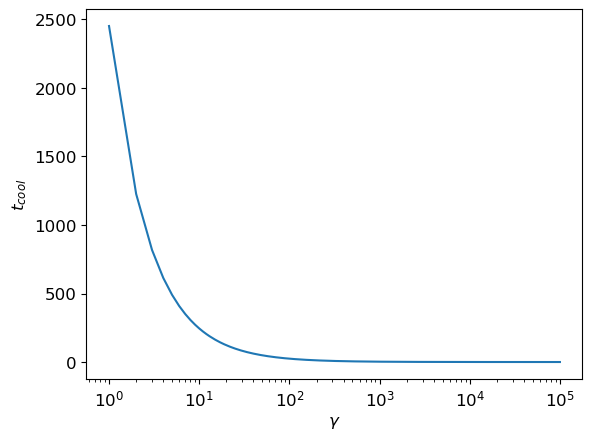

In [18]:
def t_cool(gamma):
    # pipeline to plot power spectrum of single e of gamma y
    const_dict=constants()
    q=const_dict['q']   # Charge of an electron
    B=const_dict['B']   # Magnetic field of ISM, CHECK
    m=const_dict['m_e'] # Mass of an electron
    c=const_dict['c']   # Speed of light
    alpha=const_dict['alpha']
    #--------#  
    sigmaT=astropy_const.sigma_T.cgs
    Beta=100 #hmmm
    tcool= ((6*np.pi)*m*c) / (sigmaT*(gamma)*(Beta**2)* B**2)
    return tcool
plt.plot(gammas,t_cool(gammas).to('yr'));plt.xscale('log');plt.ylabel(r'$t_{cool}$');plt.xlabel(r'$\gamma$')

Create Emission Spectrum array with cooling included in the number function

In [19]:
p_25=2.5
Ptot_cool=calctot_Spectrum_funcGamma_cool(w,gammas,p=p_25)

Create power law fits and find intersection of fits to give $\omega_{cool}$ and $\omega_{min}$ values

In [20]:
pow_fit=fit_line(Ptot_cool,w,10**6,p_25,'power')*w.value**(-(p_25 - 1.0)/2.0)
cool_fit=fit_line(Ptot_cool,w,10**9,p_25,'cooling') *w.value**(-(p_25)/2.0)
min_fit=fit_line(Ptot_cool,w,10**-1,p_25,'min')*w.value**(1/3) 
#------#
wcool=intersect(w,pow_fit,cool_fit).value  #find intersection of pow and cool which gives omega cool
wmin=intersect(w,pow_fit,min_fit).value    #find intersection of pow and min which gives omega min

Plot the afterglow emission spectrum alongside the electron number power law function with cooling now implemented

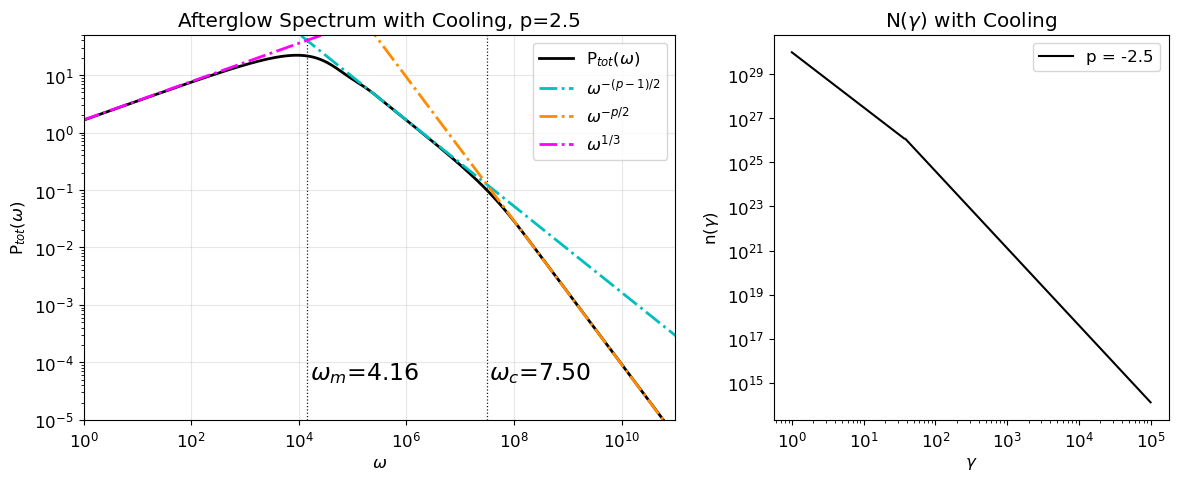

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 5),gridspec_kw={'width_ratios': [1.5,1]})
plt.rcParams.update({'font.size': 12})
ax1.plot(w,Ptot_cool,'k',linewidth=2,label=r'P$_{tot}(\omega)$');
fitwidth=2;ybounds=[10**-5,10**1.7]
min_={'color':'magenta','line':'-.'};cool_={'color':'darkorange','line':'-.'};pow_={'color':'c','line':'-.'}
ax1.plot(w,pow_fit,color=pow_['color'],linestyle=pow_['line'],linewidth=fitwidth,label=r'$\omega^{-(p-1)/2}$')
ax1.plot(w,cool_fit,color=cool_['color'],linestyle=cool_['line'],linewidth=fitwidth,label=r'$\omega^{-p/2}$')
ax1.plot(w,min_fit,color=min_['color'],linestyle=min_['line'],linewidth=fitwidth,label=r'$\omega^{1/3}$')
ax2.plot(gammas,10**30 *N_cool(gammas,p_25),'k',label='p = -2.5')
ax1.vlines(wcool,ybounds[0],ybounds[1],linewidth=0.9,color='black',alpha=0.9,linestyle=':')
ax1.vlines(wmin,ybounds[0],ybounds[1],linewidth=0.9,color='black',alpha=0.9,linestyle=':')
ax1.text(1.1*wcool,5*ybounds[0],fr'$\omega_{{c}}$={np.log10(wcool):.2f}',{'fontsize': 17})
ax1.text(1.1*wmin,5*ybounds[0],fr'$\omega_{{m}}$={np.log10(wmin):.2f}',{'fontsize': 17})
ax1.legend();ax1.set_xscale('log');ax1.set_yscale('log');ax1.set_xlabel(r'$\omega$');ax1.set_ylabel(r'P$_{tot}(\omega$)');
ax2.legend();ax2.set_xscale('log');ax2.set_yscale('log');ax2.set_ylabel(r'n($\gamma$)');plt.xlabel(r'$\gamma$')
ax1.set_xlim([10**0,10**11]);ax1.set_ylim(ybounds);ax1.grid(alpha=0.3);ax1.set_title(f'Afterglow Spectrum with Cooling, p={p_25}');ax2.set_title(fr'N($\gamma$) with Cooling');

Create Emission Spectrum array with new p value of 4

In [23]:
Ptot_cool_p4=calctot_Spectrum_funcGamma_cool(w,gammas,p=4)

Create power law fits and find intersection of fits to give $\omega_{cool}$ and $\omega_{min}$ values

In [24]:
p4=4
pow_fit=fit_line(Ptot_cool_p4,w,10**6,p4,'power')*w.value**(-(p4 - 1.0)/2.0)
cool_fit=fit_line(Ptot_cool_p4,w,10**9,p4,'cooling') *w.value**(-(p4)/2.0)
min_fit=fit_line(Ptot_cool_p4,w,10**-1,p4,'min')*w.value**(1/3)
#------#
wcool=intersect(w,pow_fit,cool_fit).value #find intersection of pow and cool which gives omega cool
wmin=intersect(w,pow_fit,min_fit).value   #find intersection of pow and min which gives omega min

Plot the afterglow emission spectrum with cooling with a larger p value ($p=4$) for the electron abundance power law function

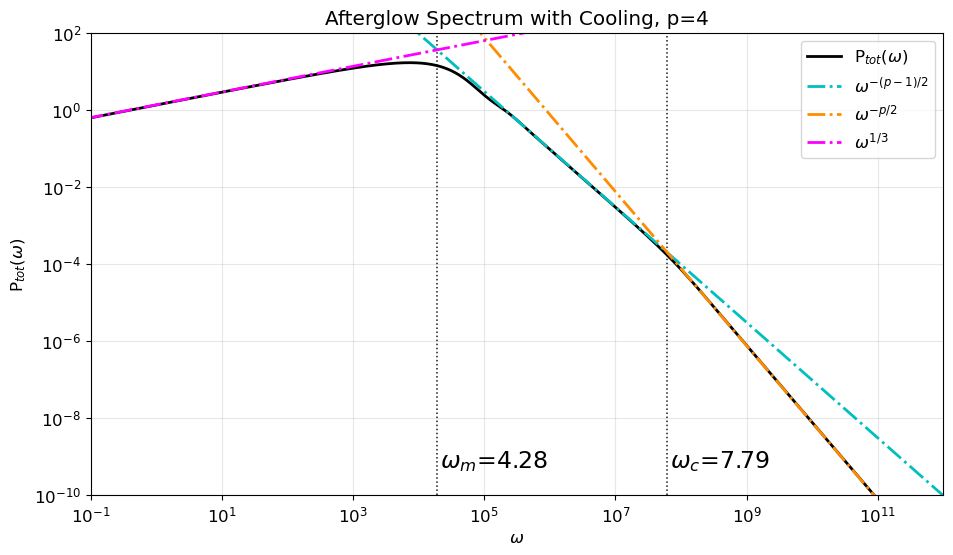

In [25]:
plt.figure(figsize=(11,6)) 
plt.plot(w,Ptot_cool_p4,'k',linewidth=2,label=r'P$_{tot}(\omega)$');
fitwidth=2;ybounds=[10**-10,10**2]
plt.plot(w,pow_fit,color=pow_['color'],linestyle=pow_['line'],linewidth=fitwidth,label=r'$\omega^{-(p-1)/2}$')
plt.plot(w,cool_fit,color=cool_['color'],linestyle=cool_['line'],linewidth=fitwidth,label=r'$\omega^{-p/2}$')
plt.plot(w,min_fit,color=min_['color'],linestyle=min_['line'],linewidth=fitwidth,label=r'$\omega^{1/3}$')
plt.vlines(wcool,ybounds[0],ybounds[1],linewidth=1.1,color='black',alpha=0.9,linestyle=':')
plt.vlines(wmin,ybounds[0],ybounds[1],linewidth=1.1,color='black',alpha=0.9,linestyle=':')
plt.text(1.1*wcool,5*ybounds[0],fr'$\omega_{{c}}$={np.log10(wcool):.2f}',{'fontsize': 17})
plt.text(1.1*wmin,5*ybounds[0],fr'$\omega_{{m}}$={np.log10(wmin):.2f}',{'fontsize': 17})
plt.legend();plt.xscale('log');plt.yscale('log');plt.xlabel(r'$\omega$');
plt.ylabel(r'P$_{tot}(\omega$)');plt.xlim([10**-1,10**12]);plt.ylim(ybounds);
plt.grid(alpha=0.3);plt.title(f'Afterglow Spectrum with Cooling, p=4');
#plt.savefig('./Afterglow_Spectrum_mark4.png')

****
## 4) Introduce $~~\gamma_{min}$

> #### Code:

Changing all the inputs based on our new $\gamma$ array with $\gamma_{min}$ implemented


In [26]:
gamma_bound_min=[5,10**5]
gammas_cut=np.linspace(min(gamma_bound_min),max(gamma_bound_min),num=10**5)
min_w_c_cut=w_crit(min(gammas_cut)).value # Hz
max_w_c_cut=w_crit(max(gammas_cut)).value # Hz

minscale=10**-9
maxscale=10**0.5

log_min_wc=np.log10(minscale*min_w_c_cut)
log_max_wc=np.log10(maxscale*max_w_c_cut)
w_cut=np.logspace(log_min_wc,log_max_wc,num=1000) *u.Hz
nu = w_cut/(2.0*np.pi)

Create Emission Spectrum array

In [27]:
p=2.5
Ptot_cut=calctot_Spectrum_funcGamma_cool(w_cut,gammas_cut,p=p)

All together now! We plot the afterglow emission spectrum from a power law distribution of electrons, with a cooling break and a value of $\gamma_{min}=5$

Text(0.5, 1.0, 'Afterglow Spectrum with Cooling, p=2.5')

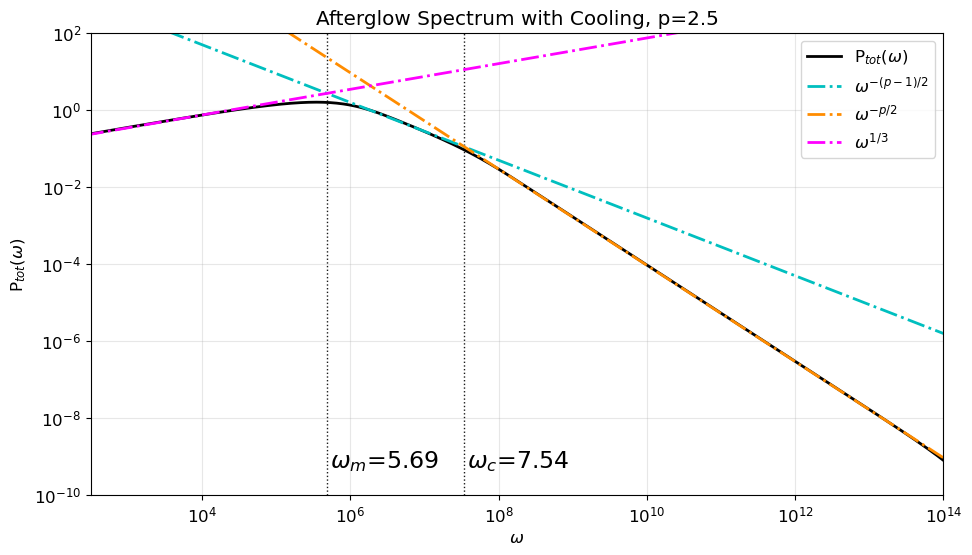

In [28]:
p25=2.5
pow_fit=fit_line(Ptot_cut,w_cut,10**7,p25,'power')*w_cut.value**(-(p25 - 1.0)/2.0)
cool_fit=fit_line(Ptot_cut,w_cut,10**9,p25,'cooling') *w_cut.value**(-(p25)/2.0)
min_fit=fit_line(Ptot_cut,w_cut,10**4,p25,'min')*w_cut.value**(1/3)
#------#
wcool=intersect(w_cut,pow_fit,cool_fit).value;wmin=intersect(w_cut,pow_fit,min_fit).value
plt.figure(figsize=(11,6)) 
plt.plot(w_cut,Ptot_cut,'k',linewidth=2,label=r'P$_{tot}(\omega)$');
fitwidth=2;ybounds=[10**-10,10**2]
min_={'color':'magenta','line':'-.'};cool_={'color':'darkorange','line':'-.'};pow_={'color':'c','line':'-.'}
plt.plot(w_cut,pow_fit,color=pow_['color'],linestyle=pow_['line'],linewidth=fitwidth,label=r'$\omega^{-(p-1)/2}$')
plt.plot(w_cut,cool_fit,color=cool_['color'],linestyle=cool_['line'],linewidth=fitwidth,label=r'$\omega^{-p/2}$')
plt.plot(w_cut,min_fit,color=min_['color'],linestyle=min_['line'],linewidth=fitwidth,label=r'$\omega^{1/3}$')
plt.vlines(wcool,ybounds[0],ybounds[1],linewidth=1,color='black',alpha=0.9,linestyle=':')
plt.vlines(wmin,ybounds[0],ybounds[1],linewidth=1,color='black',alpha=0.9,linestyle=':')
plt.text(1.1*wcool,5*ybounds[0],fr'$\omega_{{c}}$={np.log10(wcool):.2f}',{'fontsize': 17})
plt.text(1.1*wmin,5*ybounds[0],fr'$\omega_{{m}}$={np.log10(wmin):.2f}',{'fontsize': 17})
plt.legend();plt.xscale('log');plt.yscale('log');plt.xlabel(r'$\omega$');plt.ylabel(r'P$_{tot}(\omega$)');plt.xlim([10**2.5,10**14]);plt.ylim(ybounds);plt.grid(alpha=0.3);plt.title(f'Afterglow Spectrum with Cooling, p={p_25}')
#plt.savefig('./Afterglow_Spectrum_mark4.png')

We find that introducing $\gamma_{min}$ does shift $\omega_{m}$, as expected

### fin